# 🧠 Clasificador de Estado de Salud con PyTorch

Este proyecto utiliza una red neuronal profunda (MLP) implementada en PyTorch para clasificar el estado de salud de pacientes en tres categorías: **mala**, **regular** o **buena**, usando un conjunto de datos tabulares.

---


## Importar librerias

In [60]:
# Manejo de datos
import numpy as np
import pandas as pd
import random
import os

# Modelos de Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gráficos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version torch: {torch.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")

Versión de las librerias utilizadas:
- Version torch: 2.7.1+cpu
- Version pandas: 2.2.3
- Version numpy: 2.2.6
- Version sklearn: 2.2.3


## Lectura del dataset

In [61]:
try:
    data = pd.read_csv('Datasets\diabetes_012_health_indicators_BRFSS2015.csv')
    print("Archivo cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Archivo cargado correctamente.


In [3]:
data.head(5)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [62]:
seed = 110425
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [63]:
#Resample
class_0 = data[data['Diabetes_012'] == 0].sample(n=4631, random_state=42) 
class_1 = data[data['Diabetes_012'] == 1].sample(n=4631, random_state=42) 
class_2 = data[data['Diabetes_012'] == 2].sample(n=4631, random_state=42) 
balanced_train_data_01 = pd.concat([class_0, class_1]).sample(frac=1, random_state=42).reset_index(drop=True)
balanced_train_data_12 = pd.concat([class_1, class_2]).sample(frac=1, random_state=42).reset_index(drop=True)
balanced_train_data_02 = pd.concat([class_0, class_2]).sample(frac=1, random_state=42).reset_index(drop=True)


In [64]:
x_01 = balanced_train_data_01.drop(columns=["Diabetes_012"]).to_numpy() # Datos de entrenamiento
y_01 = balanced_train_data_01["Diabetes_012"].to_numpy()
scaler = StandardScaler()
x_01 = scaler.fit_transform(x_01)
X_train_01, X_test_01, y_train_01, y_test_01 = train_test_split(x_01, y_01, test_size=0.15, random_state=42, stratify=y_01)
X_train_01, X_val_01, y_train_01, y_val_01 = train_test_split(X_train_01, y_train_01, test_size=0.1, random_state=42, stratify=y_train_01)

In [65]:
#Formato correcto
#Train
X_train_01 = torch.tensor(X_train_01, dtype=torch.float32)
y_train_01 = torch.tensor(y_train_01, dtype=torch.long)

#Val
X_val_01 = torch.tensor(X_val_01, dtype=torch.float32)
y_val_01 = torch.tensor(y_val_01, dtype=torch.long)

#Test
X_test_01 = torch.tensor(X_test_01, dtype=torch.float32)
y_test_01 = torch.tensor(y_test_01, dtype=torch.long)

In [66]:
x_12 = balanced_train_data_12.drop(columns=["Diabetes_012"]).to_numpy() # Datos de entrenamiento
y_12 = balanced_train_data_12["Diabetes_012"].to_numpy()
scaler = StandardScaler()
x_12 = scaler.fit_transform(x_12)
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(x_12, y_12, test_size=0.15, random_state=42, stratify=y_12)
X_train_12, X_val_12, y_train_12, y_val_12 = train_test_split(X_train_12, y_train_12, test_size=0.1, random_state=42, stratify=y_train_12)

In [67]:
#Formato correcto
#Train
X_train_12 = torch.tensor(X_train_12, dtype=torch.float32)
y_train_12 = torch.tensor(y_train_12, dtype=torch.long)

#Val
X_val_12 = torch.tensor(X_val_12, dtype=torch.float32)
y_val_12 = torch.tensor(y_val_12, dtype=torch.long)

#Test
X_test_12 = torch.tensor(X_test_12, dtype=torch.float32)
y_test_12 = torch.tensor(y_test_12, dtype=torch.long)

In [68]:
x_02 = balanced_train_data_02.drop(columns=["Diabetes_012"]).to_numpy() # Datos de entrenamiento
y_02 = balanced_train_data_02["Diabetes_012"].to_numpy()
scaler = StandardScaler()
x_02 = scaler.fit_transform(x_02)
X_train_02, X_test_02, y_train_02, y_test_02 = train_test_split(x_02, y_02, test_size=0.15, random_state=42, stratify=y_02)
X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X_train_02, y_train_02, test_size=0.1, random_state=42, stratify=y_train_02)

In [69]:
#Formato correcto
#Train
X_train_02 = torch.tensor(X_train_02, dtype=torch.float32)
y_train_02 = torch.tensor(y_train_02, dtype=torch.long)

#Val
X_val_02 = torch.tensor(X_val_02, dtype=torch.float32)
y_val_02 = torch.tensor(y_val_02, dtype=torch.long)

#Test
X_test_02 = torch.tensor(X_test_02, dtype=torch.float32)
y_test_02 = torch.tensor(y_test_02, dtype=torch.long)

In [70]:
batchsize = 32
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [71]:

train_data_01 = DiabetesDataset(X_train_01, y_train_01)
val_data_01 = DiabetesDataset(X_val_01, y_val_01)
test_data_01 = DiabetesDataset(X_test_01, y_test_01)

train_loader_01 = DataLoader(train_data_01, batch_size=batchsize, shuffle=True)
val_loader_01 = DataLoader(val_data_01, batch_size=batchsize, shuffle=False)
test_loader_01 = DataLoader(test_data_01, batch_size=batchsize, shuffle=False)

In [72]:

train_data_12 = DiabetesDataset(X_train_12, y_train_12)
val_data_12 = DiabetesDataset(X_val_12, y_val_12)
test_data_12 = DiabetesDataset(X_test_12, y_test_12)

train_loader_12 = DataLoader(train_data_12, batch_size=batchsize, shuffle=True)
val_loader_12 = DataLoader(val_data_12, batch_size=batchsize, shuffle=False)
test_loader_12 = DataLoader(test_data_12, batch_size=batchsize, shuffle=False)

In [74]:

train_data_02 = DiabetesDataset(X_train_02, y_train_02)
val_data_02 = DiabetesDataset(X_val_02, y_val_02)
test_data_02 = DiabetesDataset(X_test_02, y_test_02)

train_loader_02 = DataLoader(train_data_02, batch_size=batchsize, shuffle=True)
val_loader_02 = DataLoader(val_data_02, batch_size=batchsize, shuffle=False)
test_loader_02 = DataLoader(test_data_02, batch_size=batchsize, shuffle=False)

In [79]:
#Definamos un modelo para trabajar
#Vamos a hacerlo más complejo de lo necesario

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hc1 = nn.Linear(21, 256)
        self.hc2 = nn.Linear(256, 128)
        self.hc3 = nn.Linear(128, 64)
        self.hc4 = nn.Linear(64, 3)
        #self.hc4 = nn.Linear(64, 2)
        #self.act = nn.ELU()
        self.act = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        #self.act = nn.ReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.2)

    def forward(self, input):
        l1 = self.dp1(self.act(self.hc1(input)))
        l2 = self.dp2(self.act(self.hc2(l1)))
        #l1 = self.act(self.hc1(input))
        #l2 = self.act(self.hc2(l1))
        l3 = self.act(self.hc3(l2))
        #output = self.sigmoid(self.hc4(l3))
        output = self.hc4(l3)
        return output

In [80]:
testeo_01 = MLP()
testeo_12 = MLP()
testeo_02 = MLP()
lr = 1e-4
opt_01 = torch.optim.Adam(testeo_01.parameters(), lr=lr, weight_decay=1e-4)
opt_12 = torch.optim.Adam(testeo_12.parameters(), lr=lr, weight_decay=1e-4)
opt_02 = torch.optim.Adam(testeo_02.parameters(), lr=lr, weight_decay=1e-4)
# lr = 1e-4
# opt_01 = torch.optim.SGD(testeo_01.parameters(), lr=lr, weight_decay=1e-4)
# opt_12 = torch.optim.SGD(testeo_12.parameters(), lr=lr, weight_decay=1e-4)
# opt_02 = torch.optim.SGD(testeo_02.parameters(), lr=lr, weight_decay=1e-4)
# lr = 1e-4
# opt_01 = torch.optim.RMSprop(testeo_01.parameters(), lr=lr, weight_decay=1e-4)
# opt_12 = torch.optim.RMSprop(testeo_12.parameters(), lr=lr, weight_decay=1e-4)
# opt_02 = torch.optim.RMSprop(testeo_02.parameters(), lr=lr, weight_decay=1e-4)
# loss_func_01 = nn.BCEWithLogitsLoss()
# loss_func_12 = nn.BCEWithLogitsLoss()
# loss_func_02 = nn.BCEWithLogitsLoss()

# loss_func_01 = nn.BCELoss()
# loss_func_12 = nn.BCELoss()
# loss_func_02 = nn.BCELoss()

loss_func_01 = nn.CrossEntropyLoss()
loss_func_12 = nn.CrossEntropyLoss()
loss_func_02 = nn.CrossEntropyLoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)


In [20]:
lambda_l1 = 1e-3
def l1_penalty(model):
    l1 = 0.0
    for param in model.parameters():
        #l1 += param.abs().sum() #si cambiaramos abs() por pow(2.0) tendriamos L2
        if param.requires_grad and len(param.shape) > 1:
            l1 += torch.norm(param, p=1)
    return l1

In [81]:
#Entrenamiento
# lr = 1e-4
# opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)

n_epochs = 1000
history_01 = {
    "TL" : [],
    "VL" : []
}
early_stopping = {
    "delta" : 1e-5,
    "patience": 10
}
best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo_01.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader_01:  
      output = testeo_01(X_batch)
      loss = loss_func_01(output, y_batch)  #+ l1_penalty(testeo) *lambda_l1
      #scheduler.step(loss)
      
      opt_01.zero_grad()
      loss.backward()
      opt_01.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader_01)
    history_01["TL"].append(epoch_loss)

    testeo_01.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader_01:
      with torch.no_grad():
        preds_val = testeo_01(X_batch)
      val_loss = loss_func_01(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader_01)
    history_01["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Terminando el entrenamiento en la época 16


In [82]:
#Entrenamiento
# lr = 1e-4
# opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)

n_epochs = 1000
history_12 = {
    "TL" : [],
    "VL" : []
}
early_stopping = {
    "delta" : 1e-5,
    "patience": 10
}
best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo_12.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader_12:  
      output = testeo_12(X_batch)
      loss = loss_func_12(output, y_batch)  #+ l1_penalty(testeo) *lambda_l1
      #scheduler.step(loss)
      
      opt_12.zero_grad()
      loss.backward()
      opt_12.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader_12)
    history_12["TL"].append(epoch_loss)

    testeo_12.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader_12:
      with torch.no_grad():
        preds_val = testeo_12(X_batch)
      val_loss = loss_func_12(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader_12)
    history_12["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Terminando el entrenamiento en la época 30


In [83]:
#Entrenamiento
# lr = 1e-4
# opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)

n_epochs = 1000
history_02 = {
    "TL" : [],
    "VL" : []
}
early_stopping = {
    "delta" : 1e-5,
    "patience": 10
}
best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo_02.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader_02:  
      output = testeo_02(X_batch)
      loss = loss_func_02(output, y_batch)  #+ l1_penalty(testeo) *lambda_l1
      #scheduler.step(loss)
      
      opt_02.zero_grad()
      loss.backward()
      opt_02.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader_02)
    history_02["TL"].append(epoch_loss)

    testeo_02.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader_02:
      with torch.no_grad():
        preds_val = testeo_02(X_batch)
      val_loss = loss_func_02(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader_02)
    history_02["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Terminando el entrenamiento en la época 26


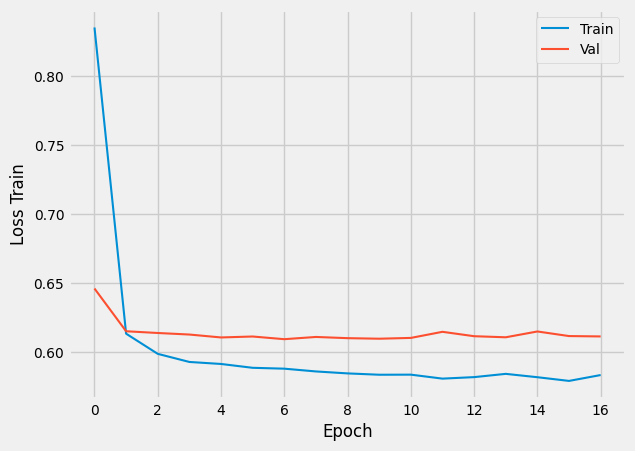

In [84]:

plt.plot(history_01["TL"], label="Train")
plt.plot(history_01["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

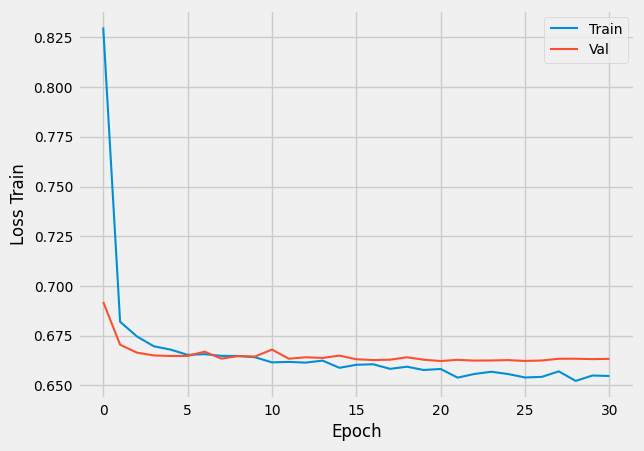

In [85]:

plt.plot(history_12["TL"], label="Train")
plt.plot(history_12["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

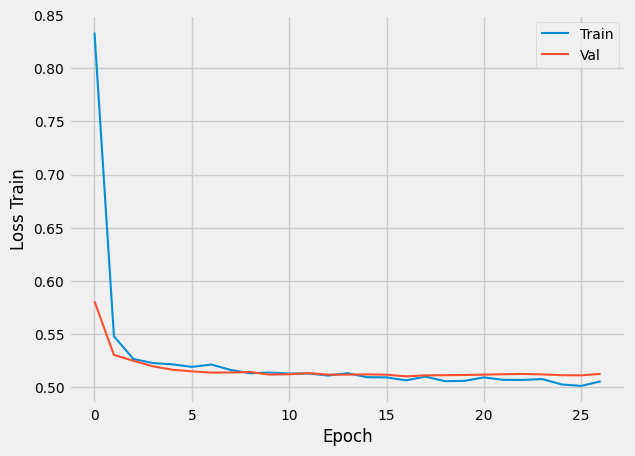

In [86]:

plt.plot(history_02["TL"], label="Train")
plt.plot(history_02["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

In [87]:
#Train
with torch.no_grad():
    output_train = testeo_01(X_train_01)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train_01, y_hat_train):.2f}')
#Testeo
with torch.no_grad():
    output = testeo_01(X_test_01)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test_01, y_hat):.2f}')

Training Accuracy: 0.70
Testing Accuracy: 0.69


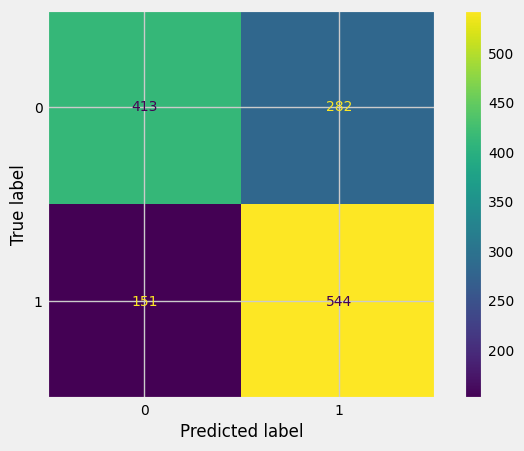

In [88]:
cm =confusion_matrix(y_test_01, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()

In [89]:
#Train
with torch.no_grad():
    output_train = testeo_12(X_train_12)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train_12, y_hat_train):.2f}')
#Testeo
with torch.no_grad():
    output = testeo_12(X_test_12)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test_12, y_hat):.2f}')

Training Accuracy: 0.63
Testing Accuracy: 0.59


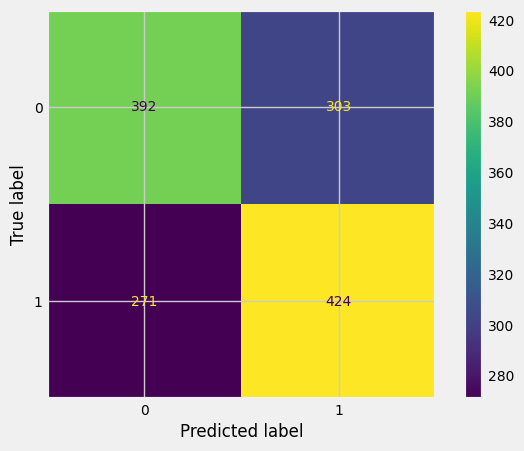

In [90]:
cm =confusion_matrix(y_test_12, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()

In [91]:
#Train
with torch.no_grad():
    output_train = testeo_02(X_train_02)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train_02, y_hat_train):.2f}')
#Testeo
with torch.no_grad():
    output = testeo_02(X_test_02)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test_02, y_hat):.2f}')

Training Accuracy: 0.76
Testing Accuracy: 0.76


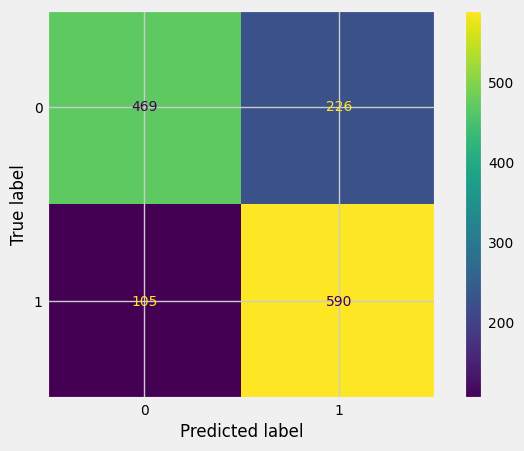

In [92]:
cm =confusion_matrix(y_test_02, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()